## 1. 필요 패키지 설치

In [3]:
import os
from dotenv import load_dotenv

load_dotenv()


EMBEDDING_MODEL_ID = 'amazon.titan-embed-text-v2:0'
CLAUDE_HAIKU_ID = 'anthropic.claude-3-haiku-20240307-v1:0'
CLAUDE_SONET_ID = 'anthropic.claude-3-5-sonnet-20240620-v1:0'

In [6]:
from langchain_aws.chat_models import ChatBedrock

chat_model = ChatBedrock(model_id=CLAUDE_HAIKU_ID)
response = chat_model.invoke("안녕하세요를 영어로")
print(response)
print("----")
print(response.content)

content='안녕하세요는 영어로 "Hello" 또는 "Good morning/afternoon/evening"으로 번역할 수 있습니다.\n\n예를 들면:\n\n- 안녕하세요 = Hello\n- 안녕하세요, 좋은 아침입니다 = Good morning\n- 안녕하세요, 좋은 오후입니다 = Good afternoon\n- 안녕하세요, 좋은 저녁입니다 = Good evening\n\n이렇게 상황에 맞게 적절한 인사말로 번역할 수 있습니다.' additional_kwargs={'usage': {'prompt_tokens': 19, 'completion_tokens': 171, 'total_tokens': 190}, 'stop_reason': 'end_turn', 'model_id': 'anthropic.claude-3-haiku-20240307-v1:0'} response_metadata={'usage': {'prompt_tokens': 19, 'completion_tokens': 171, 'total_tokens': 190}, 'stop_reason': 'end_turn', 'model_id': 'anthropic.claude-3-haiku-20240307-v1:0'} id='run-e94f7a50-b737-490f-9521-5bfcc3d360a2-0' usage_metadata={'input_tokens': 19, 'output_tokens': 171, 'total_tokens': 190}
----
안녕하세요는 영어로 "Hello" 또는 "Good morning/afternoon/evening"으로 번역할 수 있습니다.

예를 들면:

- 안녕하세요 = Hello
- 안녕하세요, 좋은 아침입니다 = Good morning
- 안녕하세요, 좋은 오후입니다 = Good afternoon
- 안녕하세요, 좋은 저녁입니다 = Good evening

이렇게 상황에 맞게 적절한 인사말로 번역할 수 있습니다.


## 2. 상태 그래프(StateGraph) 생성

In [7]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

class State(TypedDict):
    # 메시지 리스트를 유지하며 새로운 메시지를 추가하는 reducer 함수 지정
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

## 3. 챗봇 노드 생성

In [12]:
from langchain_aws.chat_models import ChatBedrock

llm = ChatBedrock(model_id="anthropic.claude-3-5-sonnet-20240620-v1:0")

def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

## 4. 그래프 시작 및 종료 지점 설정

In [13]:
# START -> chatbot -> END

graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)


## 5. 그래프 컴파일 및 실행

In [15]:
graph = graph_builder.compile()

## 6. 그래프 시각화 (옵션)

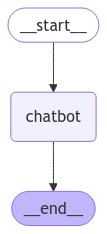

In [16]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

## 7. 챗봇 실행

In [17]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [("user", user_input)]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break
        stream_graph_updates(user_input)
    except:
        # 입력 함수가 불가능할 때 처리
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Assistant: 말씨를 좀 더 정중하게 해주시면 감사하겠습니다. 저는 당신을 돕기 위해 여기 있습니다. 무엇을 도와드릴까요?
Assistant: '어쩔요'는 주로 가벼운 대화나 친구 사이에서 사용되는 표현입니다. 상황에 따라 다양한 의미로 해석될 수 있어요:

1. "어쩔 수 없어요" 의 줄임말로, 상황을 받아들이는 뉘앙스
2. "어떻게 해요?" 의 줄임말로, 질문의 의미
3. 상대방의 말에 대한 가벼운 반응이나 동의
4. 때로는 약간의 짜증이나 불만을 표현할 때도 사용

정확한 의미는 대화의 맥락과 톤에 따라 달라질 수 있습니다. 공식적인 자리나 윗사람과의 대화에서는 적절하지 않을 수 있으니 주의가 필요해요.


ERROR:root:Error raised by bedrock service: An error occurred (ValidationException) when calling the InvokeModel operation: messages.0: all messages must have non-empty content except for the optional final assistant message


User: What do you know about LangGraph?
Assistant: LangGraph is a library designed to help create language model agents and workflows using LangChain. It provides tools for building multi-agent systems and complex reasoning chains with large language models. LangGraph aims to make it easier to create stateful, multi-step AI workflows and agent interactions. However, as I don't have perfect up-to-date knowledge about its latest features or developments, I'd recommend checking the official documentation or recent announcements for the most current information.


In [18]:
graph.invoke({'messages':["안녕하세요를 영어로"]})

{'messages': [HumanMessage(content='안녕하세요를 영어로', additional_kwargs={}, response_metadata={}, id='d8b52730-b731-40da-904c-0ac4274cc56b'),
  AIMessage(content='"안녕하세요"를 영어로 표현하는 방법은 상황에 따라 다양합니다:\n\n1. Hello - 가장 일반적인 인사말\n\n2. Hi - 친근하고 informal한 인사말\n\n3. Good morning - 아침 인사\n\n4. Good afternoon - 오후 인사\n\n5. Good evening - 저녁 인사\n\n6. How are you? - "어떻게 지내세요?"라는 의미로 인사할 때 사용\n\n7. Nice to meet you - 처음 만났을 때 사용하는 인사\n\n8. Welcome - 환영의 의미를 담은 인사\n\n상황과 대화 상대에 따라 적절한 표현을 선택하면 됩니다. 가장 보편적으로 사용되는 것은 "Hello"와 "Hi"입니다.', additional_kwargs={'usage': {'prompt_tokens': 19, 'completion_tokens': 251, 'total_tokens': 270}, 'stop_reason': 'end_turn', 'model_id': 'anthropic.claude-3-5-sonnet-20240620-v1:0'}, response_metadata={'usage': {'prompt_tokens': 19, 'completion_tokens': 251, 'total_tokens': 270}, 'stop_reason': 'end_turn', 'model_id': 'anthropic.claude-3-5-sonnet-20240620-v1:0'}, id='run-62f149a9-fb85-4064-a316-a0be56f29a5b-0', usage_metadata={'input_tokens': 19, 'output_tokens': 251, 't

---

# Part2: 도구를 활용한 챗봇 향상

## TavilySearchResults 사용

In [20]:
# 도구 정의
from langchain_community.tools.tavily_search import TavilySearchResults

tool = TavilySearchResults(max_results=2)
tools = [tool]
tool.invoke("What's a 'node' in LangGraph?")

[{'url': 'https://www.datacamp.com/tutorial/langgraph-tutorial',
  'content': 'Jun 26, 2024 · Nodes: Nodes represent units of work within your LangGraph. They are typically Python functions that perform a specific task, such as:.'},
 {'url': 'https://www.ionio.ai/blog/a-comprehensive-guide-about-langgraph-code-included',
  'content': "A node can be any function or tool your agent uses in langgraph and these nodes are connected with other nodes using edges. Every workflow ends with a “END”\xa0...What is Langgraph? · Creating a Basic Workflow... · Mini Project: Let's Create a..."}]

## 그래프 빌드

In [21]:
from langchain_aws.chat_models import ChatBedrock
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

llm = ChatBedrock(model_id="anthropic.claude-3-5-sonnet-20240620-v1:0")
llm_with_tools = llm.bind_tools(tools)

graph_builder = StateGraph(State)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

## 도구 노드 추가

In [22]:
class BasicToolNode:
    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")

        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}

tool_node = BasicToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

## 조건부 경로 설정

In [23]:
def route_tools(state: State):
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")

    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END

graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    {"tools": "tools", END: END},
)

graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

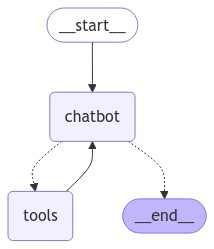

In [26]:
# 그래프로 확인
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

## 챗봇 실행

In [31]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [("user", user_input)]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break
        stream_graph_updates(user_input)
    except:
        # 입력 함수가 불가능할 때 처리
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Assistant: 
Assistant: [{"url": "https://kr.investing.com/equities/samsung-electronics-co-ltd", "content": "Samsung Electronics Co Ltd의 오늘 주가는? Samsung Electronics Co Ltd의 오늘 주가는 60,600입니다. Samsung Electronics Co Ltd의 주식 티커는? Samsung Electronics ...과거 데이터 · 차트 · 기술 분석 · 배당"}, {"url": "https://stock.mk.co.kr/price/home/KR7005930003", "content": "삼성전자 (005930). 10.04 15:33. 코스피. 전기,전자. 60,600. 700. -1.14%. 전일, 61,300. 시가, 61,000. 고가, 61,700. 저가, 60,500. 상한가, 79,600."}]
Assistant: 삼성전자의 오늘 주가에 대한 정보를 찾아보았습니다. 현재 가장 최신 정보를 기준으로 말씀드리겠습니다.

삼성전자(005930)의 오늘 주가는 60,600원입니다. 이는 전일 대비 700원(-1.14%) 하락한 수치입니다. 

추가적인 거래 정보는 다음과 같습니다:
- 전일 종가: 61,300원
- 시가: 61,000원
- 고가: 61,700원
- 저가: 60,500원

이 정보는 한국 시간으로 오후 3시 33분 기준의 데이터입니다. 주식 시장은 실시간으로 변동되므로, 현재 시점과는 약간의 차이가 있을 수 있습니다. 

투자 결정을 내리실 때는 이 정보뿐만 아니라 다양한 경제 지표와 회사의 실적, 향후 전망 등을 종합적으로 고려하시는 것이 좋습니다. 또한, 실시간 주가 확인을 위해서는 증권사 앱이나 웹사이트를 이용하시는 것이 가장 정확할 것입니다.
Goodbye!


## 최종 코드(ToolNode 사용)

In [25]:
from langchain_aws.chat_models import ChatBedrock
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.graph import StateGraph
from langgraph.prebuilt import ToolNode, tools_condition

llm = ChatBedrock(model_id="anthropic.claude-3-5-sonnet-20240620-v1:0")
tool = TavilySearchResults(max_results=2)
tools = [tool]

llm_with_tools = llm.bind_tools(tools)
graph_builder = StateGraph(State)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)

graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")
graph = graph_builder.compile()

---

# Part 3

In [32]:
from langchain_aws.chat_models import ChatBedrock
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver
from typing_extensions import TypedDict
from typing import Annotated

class State(TypedDict):
    messages: Annotated[list, add_messages]

# 그래프 빌더 생성
graph_builder = StateGraph(State)

# 도구 및 LLM 설정
tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatBedrock(model_id=CLAUDE_HAIKU_ID)
llm_with_tools = llm.bind_tools(tools)

# 챗봇 노드 정의
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

# ToolNode 추가
tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

# 조건부 엣지 설정 (도구 호출 여부에 따른 흐름 제어)
graph_builder.add_conditional_edges("chatbot", tools_condition)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

# 메모리 체크포인터 추가
memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)


In [33]:
config = {"configurable": {"thread_id": "1"}}
user_input = "Hi there! My name is Will."

events = graph.stream({"messages": [("user", user_input)]}, config, stream_mode="values")
for event in events:
    event["messages"][-1].pretty_print()


================================ Human Message =================================

Hi there! My name is Will.
================================== Ai Message ==================================

It's nice to meet you, Will! I'm an AI assistant here to help out however I can. Please let me know if you have any questions or if there's anything I can assist with.


In [34]:
user_input = "Remember my name?"

events = graph.stream({"messages": [("user", user_input)]}, config, stream_mode="values")
for event in events:
    event["messages"][-1].pretty_print()


================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

Yes, I remember your name is Will. It's a pleasure to meet you!


In [35]:
# 다른 thread_id 사용 -> 기억 못함

events = graph.stream({"messages": [("user", user_input)]}, {"configurable": {"thread_id": "2"}}, stream_mode="values")
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

I'm afraid I don't actually have a persistent memory of your name. As an AI assistant, I don't have the capability to remember individual users and their personal information. I respond based on the current conversation, without retaining details about previous interactions. Could you please remind me your name so I can address you properly?


In [36]:
snapshot = graph.get_state(config)
snapshot

StateSnapshot(values={'messages': [HumanMessage(content='Hi there! My name is Will.', additional_kwargs={}, response_metadata={}, id='1e0800fc-c04c-4916-b32f-34c047d7d0b1'), AIMessage(content="It's nice to meet you, Will! I'm an AI assistant here to help out however I can. Please let me know if you have any questions or if there's anything I can assist with.", additional_kwargs={'usage': {'prompt_tokens': 375, 'completion_tokens': 44, 'total_tokens': 419}, 'stop_reason': 'end_turn', 'model_id': 'anthropic.claude-3-haiku-20240307-v1:0'}, response_metadata={'usage': {'prompt_tokens': 375, 'completion_tokens': 44, 'total_tokens': 419}, 'stop_reason': 'end_turn', 'model_id': 'anthropic.claude-3-haiku-20240307-v1:0'}, id='run-8d253bea-23b1-4160-9c58-3e3eed0d197c-0', usage_metadata={'input_tokens': 375, 'output_tokens': 44, 'total_tokens': 419}), HumanMessage(content='Remember my name?', additional_kwargs={}, response_metadata={}, id='b5121a69-99e4-4cc6-a543-cc55a2eb2991'), AIMessage(content

In [38]:
snapshot.values['messages']

[HumanMessage(content='Hi there! My name is Will.', additional_kwargs={}, response_metadata={}, id='1e0800fc-c04c-4916-b32f-34c047d7d0b1'),
 AIMessage(content="It's nice to meet you, Will! I'm an AI assistant here to help out however I can. Please let me know if you have any questions or if there's anything I can assist with.", additional_kwargs={'usage': {'prompt_tokens': 375, 'completion_tokens': 44, 'total_tokens': 419}, 'stop_reason': 'end_turn', 'model_id': 'anthropic.claude-3-haiku-20240307-v1:0'}, response_metadata={'usage': {'prompt_tokens': 375, 'completion_tokens': 44, 'total_tokens': 419}, 'stop_reason': 'end_turn', 'model_id': 'anthropic.claude-3-haiku-20240307-v1:0'}, id='run-8d253bea-23b1-4160-9c58-3e3eed0d197c-0', usage_metadata={'input_tokens': 375, 'output_tokens': 44, 'total_tokens': 419}),
 HumanMessage(content='Remember my name?', additional_kwargs={}, response_metadata={}, id='b5121a69-99e4-4cc6-a543-cc55a2eb2991'),
 AIMessage(content="Yes, I remember your name is 